# Transitional Dynamics

Question: how does the transition until the long-run equilibrium look like?
- it will take time to reach the new equilibrium.
- short- or medium-run effects might be different from long-run, critical for welfare of different generations/cohorts.

How to solve the transition path?
1. Solve the long-run equilibrium in the long run with a change of interest (e.g., lower $\theta$)
2. Set the length of time horizon $T$. Choose $T$ so that it is large enough for the economy to converge.
3. Make initial guesses for the time series of prices.
4. Given the prices, solve the household problems.
5. Compute the implied series of aggregate variables based on the household decisions.
6. Check if the guess is close enough to the implied series. If not, update the guesses and go back to step 4 until convergence.

## Model
To focus on the essence of computational algorithm for transitional dynamics, we use a two-period model with exogenous labor supply. The problem is:

$$
\max_{c^y_t,c^o_{t+1}} ~ \ln(c^y_t) + \beta\ln(c^o_{t+1})
$$
subject to:
$$
c^y_t + a = (1-\tau)w_t\\
c^o_{t+1} = (1+r_{t+1})a + \theta w_t
$$

Firm uses capital and labor to produce final output according to the production function $F(K,N)=AK^{\alpha}N^{1-\alpha}$. Given that labor supply is exogenous, $N=1$. Also, capital market clearing implies that $K=a$. 

We can solve the problem analytically:

$$
a = \frac{\beta(1+r_{t+1})(1-\tau_t)-\theta_t}{(1+\beta)(1+r_{t+1})}w_t
$$

For each cohort, the choice is saving $a$, which pins down consumption. 

The tax rate $\tau$ is determined so that it satisfies the government budget constraint:

$$
\tau_t w_t \mu^y_t = \theta_t w_t \mu^o_t
$$

This means that the equilibrium tax rate is determined as
$$
\tau_t = \theta_t\frac{\mu^o_t}{\mu^y_t}
$$

Think that the population growth rate is zero (ie., $\mu^o_t=\mu^y_t$).

In equilibrium prices are given as:
$$
r = A\alpha K^{\alpha-1}
$$
and
$$
w = A(1-\alpha) K^{\alpha}
$$


In [1]:
# SOLVE HOUSEHOLD PROBLEMS

function solve_problem(J::Int,
                       r::Vector{Float64},
                       w::Vector{Float64},
                       τ::Vector{Float64},
                       θ::Vector{Float64})

    β = 0.98

    # discretization
    amin = 1.e-5
    amax = 10.0
    na   = 100
    agrid = collect(LinRange(amin,amax,na))

    # curvature trick
    penalty=-1.e+8
    v0=penalty
    v_new = 0.0

    # solutions
    Va = zeros(na,J)
    ga = zeros(na,J)
    ga_arg = ones(Int,na,J)

    for jc in J:-1:1

        if (jc==1)
            ac_end=1
        else
            ac_end=na
        end

        if (jc==J)
            for ac in 1:ac_end
                c = (1+r[jc])*agrid[ac]+θ[jc]*w[jc-1]
                if (c>0)
                    Va[ac,jc]=log(c)
                else
                    Va[ac,jc]=penalty
                end
            end
        else
            acc_start=1
            for ac in 1:ac_end
                v0=penalty
                for acc in acc_start:na
                    c = (1+r[jc])*agrid[ac]-agrid[acc]+w[jc]
                    if (c>0)
                        v_new = log(c) + β*Va[acc,jc+1]
                    else
                        v_new = penalty
                    end
                    
                    if (v_new>v0)
                        v0=v_new
                        acc_start=acc
                    else
                        break
                    end
                end
                Va[ac,jc]=v_new
                ga_arg[ac,jc]=acc_start
                ga[ac,jc]=agrid[acc_start]
            end
        end

    end

    aj = fill(amin,J)
    pre_a = 1
    for jc in 2:J
        aj[jc]=ga[pre_a,jc-1]
        pre_a = ga_arg[pre_a,jc-1]
    end

    return aj

end

solve_problem (generic function with 1 method)

In [2]:
# SOLVE LONG RUN EQUILIBRIUM
function solve_GE(J::Int,
                r::Vector{Float64},
                w::Vector{Float64},
                τ::Vector{Float64},
                θ::Vector{Float64},
                A::AbstractFloat,
                α,δ)

    
    # convergence
    dif = 1.0
    tol = 1.e-4

    # update
    weight = 0.1
    K = 0.0
    aj = zeros(J)

    while (dif>tol)
        aj = solve_problem(J,r,w,τ,θ)
        K  = sum(aj[2:end])/(0.5*J) # assume that population mass of each generation is 0.5 st labor=1.
        imp_r = A*α*K^(α-1) - δ
        dif = abs(r[1]-imp_r) # any r[jc] is fine
        if (dif>tol)
            r .= weight*imp_r .+ (1-weight).*r
        end
    end

    r_eq = zeros(J)
    w_eq = zeros(J)
    
    K_eq = K
    r_eq .= A*α*K^(α-1) - δ
    w_eq .= A*(1-α)*K^α

    return K_eq, r_eq, w_eq
end

solve_GE (generic function with 1 method)

In [ ]:
## SOLVE TRANSITION

id = 1
# 1: an increase in θ (Δ*100%)
# 2: an increase in A (Δ*100%)
Δ = 0.5

# parameters
α = 0.33
δ = 1.0

# (STEP 2: SET THE LENGTH OF TIME HORIZON)
T = 10 # length of transition periods
J = 3 # length of one generation

# STEP 0: SOLVE INITIAL EQUILIBRIUM
# initial guesses
r = zeros(J)
w = zeros(J)
θ = zeros(J)
τ = zeros(J)
A = 1.0

r .= 0.02
w .= 1.0
θ .= 0.3
τ .= θ 
A = 1.0

K0, r0, w0 = solve_GE(J,r,w,τ,θ,A,α,δ)
θ0 = θ
τ0 = τ
A0 = A

aj0 = solve_problem(J,r,w,τ,θ) # saving rule

# STEP 1: SOLVE LONG-RUN EQUILIBRIUM
# initial guesses
r .= r0
w .= w0
if (id==1)
    θ.=(1+Δ).*θ0
    A=A0
elseif (id==2)
    θ.=θ0
    A=(1+Δ)*A0
end
τ .= θ 
K1, r1, w1 = solve_GE(J,r,w,τ,θ,A,α,δ)
θ1 = θ
τ1 = τ
A1 = A

# STEP 3: MAKE INITIAL GUESSES
rt = collect(LinRange(r0[1],r1[1],T))
wt = collect(LinRange(w0[1],w1[1],T))
θt = fill(θ0[1],T)
τt = fill(τ0[1],T)
At = fill(A0,T)
if (id==1)
    θt[2:end] .= θ1[1]
    τt[2:end] .= τ1[1]
elseif (id==2)
    At[2:end] .= A1
end


rt_imp = copy(rt)
wt_imp = copy(wt)

dif=1.0
tol=1.e-6
dif_t = zeros(T)
iter=1
maxiter=1000

Ncohort::Int = T+(J-1)*2 # +(J-1)*2 because we have (J-1) existing generations who have already made choices and (J-1) future generations born after reaching the new equilibrium

aj_cohort = zeros(J,Ncohort) # +J-1 because we have (J-1) existing generations who have already made choices

while (dif>tol)

    # STEP 4: SOLVE PROBLEMS FOR EACH COHORT
    # compute each cohort saving decision
    for tc in 1:Ncohort # +J-1 because we have (J-1) existing generations who have already made choices
        if (tc≤(J-1))
            if (tc==1)
                r .= [r0[1],r0[1],rt[tc]]
                w .= [w0[1],w0[1],wt[tc]]
                τ .= [τ0[1],τ0[1],τt[tc]]
                θ .= [θ0[1],θ0[1],θt[tc]]
            elseif (tc==2)
                r .= [r0[1],rt[tc],rt[tc+1]]
                w .= [w0[1],wt[tc],wt[tc+1]]
                τ .= [τ0[1],τt[tc],τt[tc+1]]
                θ .= [θ0[1],θt[tc],θt[tc+1]]
            end
        elseif (tc>T+(J-1))
            if (tc==T+(J-1)+2)
                r .= [rt[tc],r1[1],r1[1]]
                w .= [wt[tc],w1[1],w1[1]]
                τ .= [τt[tc],τ0[1],τ0[1]]
                θ .= [θt[tc],θ0[1],θ0[1]]
            elseif (tc==T+(J-1)+1)
                r .= [rt[tc],rt[tc+1],r1[1]]
                w .= [wt[tc],wt[tc+1],w1[1]]
                τ .= [τt[tc],τt[tc+1],τ1[1]]
                θ .= [θt[tc],θt[tc+1],θ1[1]]
            end
        else
            r .= rt[tc:tc+2]
            w .= wt[tc:tc+2]
            τ .= τt[tc:tc+2]
            θ .= θt[tc:tc+2]
        end
        

        aj_cohort[:,tc] .= solve_problem(J,r,w,τ,θ) # saving rule

        # STEP 5: COMPUTE IMPLIED PRICES
        for tc in 1:T
            aj_gen3 = aj_cohort[:,tc+2] # young
            aj_gen2 = aj_cohort[:,tc+1] # middle
            aj_gen1 = aj_cohort[:,tc]   # old
            K = (aj_gen3[1] + aj_gen2[2] + aj_gen1[3]) / (0.5*J) #population mass of each gen is 0.5 s.t. agg labor is 1.

            imp_r = A*α*K^(α-1) - δ
            imp_w = A*(1-α)*K^α

            rt_imp[tc] = r_imp
            wt_imp[tc] = w_imp

            # STEP 6: CONVERGENCE CHECK
            # check difference
            dif_r = abs(rt[tc]-rt_imp[tc])
            dif_w = abs(wt[tc]-wt_imp[tc])
            dif_t[tc] = max(dif_r,dif_w)

            # update
            rt[tc] = (rt[tc]+rt_imp[tc])/2.0
            wt[tc] = (wt[tc]+wt_imp[tc])/2.0

        end

    end

    dif = maximum(dif_t)

    println("iter=",iter,"dif=",dif)
    iter+=1

    if (iter>maxiter)
        println("iter>maxiter")
        break
    end

end

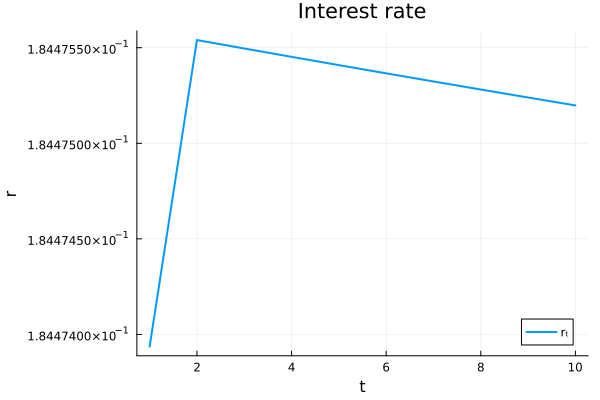

In [53]:
# plot
using Plots
t = 1:T

# rₜ
plot(t, rt, lw=2, label="rₜ", xlabel="t", ylabel="r", title="Interest rate")
display(plot(t, rt, lw=2, label="rₜ", xlabel="t", ylabel="r", title="Interest rate"))

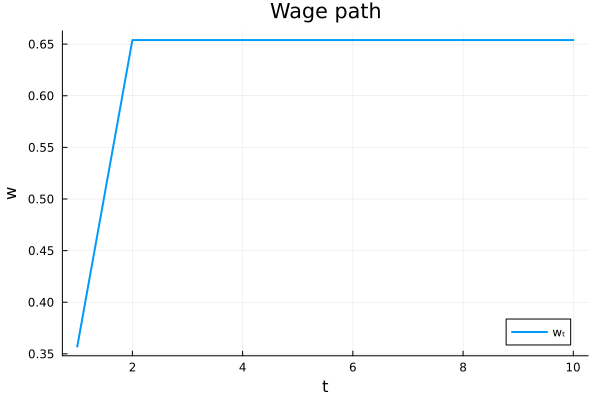

In [54]:
# wₜ (plot)
display(plot(t, wt, lw=2, label="wₜ", xlabel="t", ylabel="w", title="Wage path"))

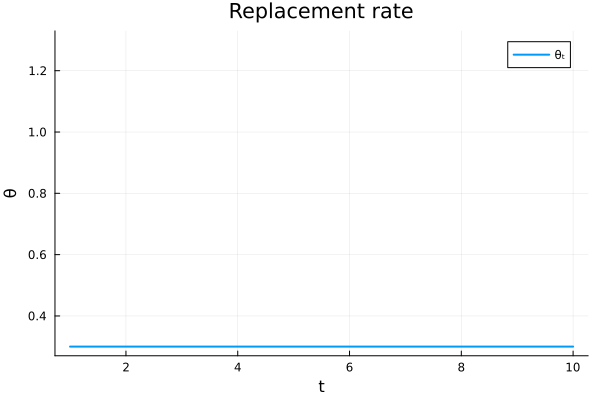

In [49]:
# θₜ (plot)
display(plot(t, θt, lw=2, label="θₜ", xlabel="t", ylabel="θ", title="Replacement rate"))

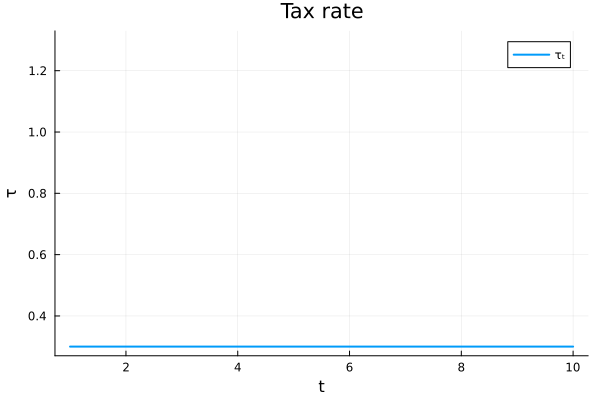

In [50]:
# τₜ (plot)
display(plot(t, τt, lw=2, label="τₜ", xlabel="t", ylabel="τ", title="Tax rate"))

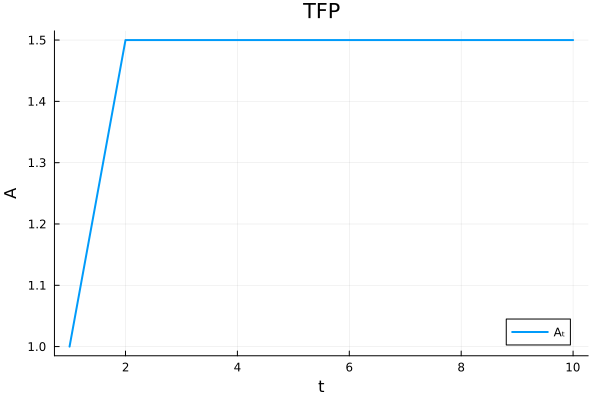

In [51]:
# Aₜ (plot)
display(plot(t, At, lw=2, label="Aₜ", xlabel="t", ylabel="A", title="TFP"))